# Redes Neuronales Artificiales Para Estimación de la Demanda Dataset Rossman

**Autor: Elias Buitrago B.**\
Bogotá, Colombia \
Actualizado: 11 Dic 2023 \
Revisado: 20 may 2024
_Nota: Código ajustado para su ejecución en Google Colaboratory_\
Verificado con las siguientes versiones: Python 3.10.12, Tensorflow: 2.13.0, Keras: 2.13.1_

## Cargar librerías
El lenguaje de programación python se apoya en librerías de código especializadas en diversas funcionalidades. Por ejemplo, si queremos graficar podemos invocar (llamar, cargar) una librerías especilizada como matplotlib. ESte empaquetamiento de código con funciones concretas y similares, se asemeja a los que hace el software R con los paquetes. A continuación, se importan las librerías requeridas para el correcto entrenamiento de redes neuronales del tipo perceptrón multicapa. Las librerías especializadas, específicamente para entrenar las redes neuronales para predecri riesgo cardiovascular son las siguientes TensorFlow (_versión 2.13.0_) y Keras (_versión 2.13.1_).

In [1]:
# Librerías básicas de Python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Librería para calcular tiempo de ejecución
from time import process_time

# Librerías para particionar conjunto de datos
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split

# Funciones requeridas de la librerías que permite entrenar redes neuronales
# artificiales
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import utils as np_utils

# Funciones requeridas de la librería para evaluar desempeño de la RNA
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

## Verificación de versiones de librerías
De manera rutinaria se recomienda hacer la verificación de la versión actual de las versiones de Python, TensorFlow y Keras. Por lo tanto a continuación se mnuestran las lineas de código para verificar las versiones de dichas librerías, incluyendo la versión del sistema operativo. Google Colaboratory se ejecuta sobre un sistema operatio Linux distribución Ubuntu,

In [2]:
import tensorflow
import keras
print("El sistema operativo base de Google Colaboratory es: ")
!lsb_release -a
print("La versión actual de Python es: ")
!python --version
print("La versión instalada de Tensorflow es: " + tensorflow.__version__)
print("La versión instalada de Keras es: " + keras.__version__)

El sistema operativo base de Google Colaboratory es: 
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy
La versión actual de Python es: 
Python 3.10.12
La versión instalada de Tensorflow es: 2.15.0
La versión instalada de Keras es: 2.15.0


## Cargar datos
En el contexto del presente taller, los datos que se utilizan para el entrenamiento, evaluación y validación se almacenan en un directorio de Google Drive del mismo usuario actual de Google Colaboratory. Para acceder a los datos solo se requiere ejecutar la primera celda de código de esta sección, luego brindar los permisos de acceo respectivo y, finalmente, cambiar la ruta de acceso al archivo de los datos.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_sales = pd.read_csv("/content/drive/MyDrive/data/rossman-store-sales/train.csv")
data_store = pd.read_csv("/content/drive/MyDrive/data/rossman-store-sales/store.csv")
# merge
data = pd.merge(data_sales, data_store, how="left", on="Store")
print(data.shape)
data.head()


<ipython-input-4-6c668b4596be>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data_sales = pd.read_csv("/content/drive/MyDrive/data/rossman-store-sales/train.csv")


(1017209, 18)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
target = data.loc[:, 'Sales'].astype(int)
data = data.drop(['Sales'], axis=1)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Customers                  1017209 non-null  int64  
 4   Open                       1017209 non-null  int64  
 5   Promo                      1017209 non-null  int64  
 6   StateHoliday               1017209 non-null  object 
 7   SchoolHoliday              1017209 non-null  int64  
 8   StoreType                  1017209 non-null  object 
 9   Assortment                 1017209 non-null  object 
 10  CompetitionDistance        1014567 non-null  float64
 11  CompetitionOpenSinceMonth  693861 non-null   float64
 12  CompetitionOpenSinceYear   693861 non-null   float64
 13  Promo2      

In [7]:
df = data.copy()

## Conteo de clases

Este es un problema de regresión, por lo tanto, a diferencia de los problemas de clasificación no es necesario revisar si existe desbalance de clases. El título de la sección se deja en este código para efectos ilustrativos y de contraste.

$\it{pd.DataFrame(target).value\_counts()}$

## Preparar datos para el entrenamiento de la RNA
En esta sección se excluyen la etapa de preprocesamiento de los datos, en la cual, se segue una metodología para asegurar la calidad de los datos. Así mismo, se excluye la etapa de análisis exploratorio de datos, en la cual, se eaplican técnicas de estadística descriptiva y, en algunos casos, inferencial. Por lo tanto, para efectos del taller, esta sección se restringue a la partición del conjunto original de datos para obtener los tres subconjguntos vitales en el entrenamiento y evaluación del modelo predictivo.

### Verificar la existencia de NAs

In [8]:
df.isna().mean()

Store                        0.000000
DayOfWeek                    0.000000
Date                         0.000000
Customers                    0.000000
Open                         0.000000
Promo                        0.000000
StateHoliday                 0.000000
SchoolHoliday                0.000000
StoreType                    0.000000
Assortment                   0.000000
CompetitionDistance          0.002597
CompetitionOpenSinceMonth    0.317878
CompetitionOpenSinceYear     0.317878
Promo2                       0.000000
Promo2SinceWeek              0.499436
Promo2SinceYear              0.499436
PromoInterval                0.499436
dtype: float64

In [9]:
df.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

### Imputación datos variable 'CompetitionDistance'
En esta sección se realizan los siguientes pasos:


*   Se calcula la prueba de Shapiro-Wilk para verificar normalidad
*   Se complementa con otra pueba para estiamción de normalidad: Anderson-Darling.
*   Se verifica normalidad de manera visual con histograma y Q-Q plot.
*   Se aplica transformación logarítmica en una nueva variable denominada 'Log_CompetitionDistance'.
*   Se verificar normalidad de la variable transformada mediante Anderson-Darling, histograma y Q-Q plot.
*   Se agrega una nueva variable transformada 'CompetitionDistanca' imputada mediante mediante.
*   Se agrega imputación mediante mediana a la variable transformada 'Log_CompetitionDistance'.



#### Realizar pruebas de normalidad

In [10]:
from scipy import stats

# Eliminar los NaN para que la prueba funcione correctamente
data_temp= df['CompetitionDistance'].dropna()

# Realizando la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(data_temp)

# Accediendo a los resultados
statistic = shapiro_test[0]  # Valor estadístico
p_value = shapiro_test[1]  # Valor p

print(f"Shapiro-Wilk Test: Statistic={statistic}, p-value={p_value}")


# Realizar la prueba de Anderson-Darling para normalidad
result = stats.anderson(df['CompetitionDistance'].dropna(), dist='norm')

print(f"Anderson-Darling Test: Statistic={result.statistic}, Significance Levels={result.significance_level}, Critical Values={result.critical_values}")


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk Test: Statistic=0.6780918836593628, p-value=0.0
Anderson-Darling Test: Statistic=97828.18659960944, Significance Levels=[15.  10.   5.   2.5  1. ], Critical Values=[0.576 0.656 0.787 0.918 1.092]


#### Verificar normalidad con un histograma y Q-Q plot

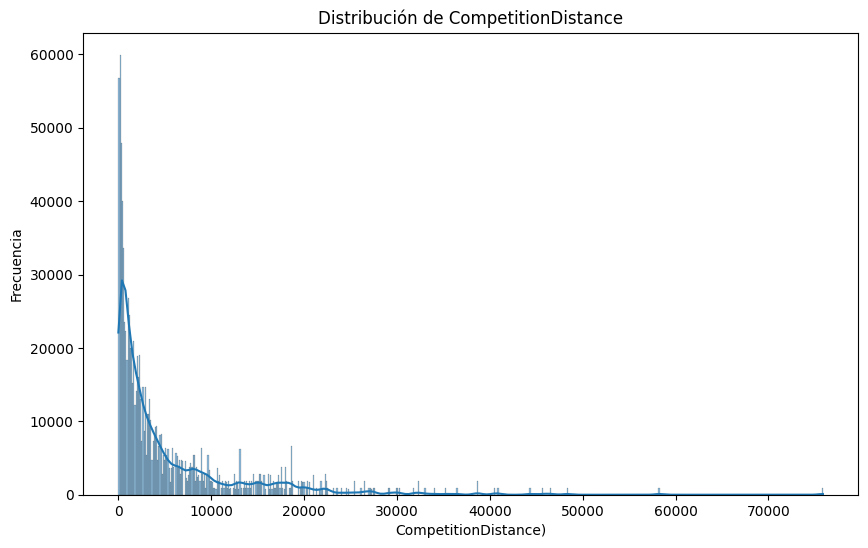

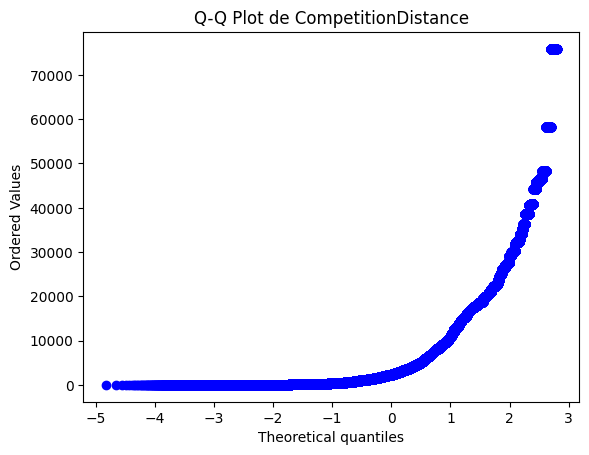

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma
plt.figure(figsize=(10, 6))
sns.histplot(df['CompetitionDistance'], kde=True)
plt.title('Distribución de CompetitionDistance')
plt.xlabel('CompetitionDistance)')
plt.ylabel('Frecuencia')
plt.show()

# Q-Q plot
import scipy.stats as stats
fig = plt.figure()
res = stats.probplot(df['CompetitionDistance'], plot=plt)
plt.title('Q-Q Plot de CompetitionDistance')
plt.show()

#### Aplicar transformación logarítmica

In [12]:
# La aplicación de esta transformación asume que no hay ceros ni valores negativos en la variable
print(f"La cantidad de ceros en 'CompetitionDistance' es: {df['CompetitionDistance'].eq(0).sum()}")

df['Log_CompetitionDistance'] = np.log(df['CompetitionDistance'])  # Se agrega 1 para manejar los ceros si existen
# df = df.drop(['CompetitionDistance'], axis=1)

La cantidad de ceros en 'CompetitionDistance' es: 0


#### Verificar resultados de la transformación logarítmica con la prueba de Anderson-Darling para normalidad, histograma y Q-Q plot

In [13]:
result = stats.anderson(df['Log_CompetitionDistance'].dropna(), dist='norm')
print(f"Anderson-Darling Test: Statistic={result.statistic}, Significance Levels={result.significance_level}, Critical Values={result.critical_values}")

Anderson-Darling Test: Statistic=3855.8715989039047, Significance Levels=[15.  10.   5.   2.5  1. ], Critical Values=[0.576 0.656 0.787 0.918 1.092]


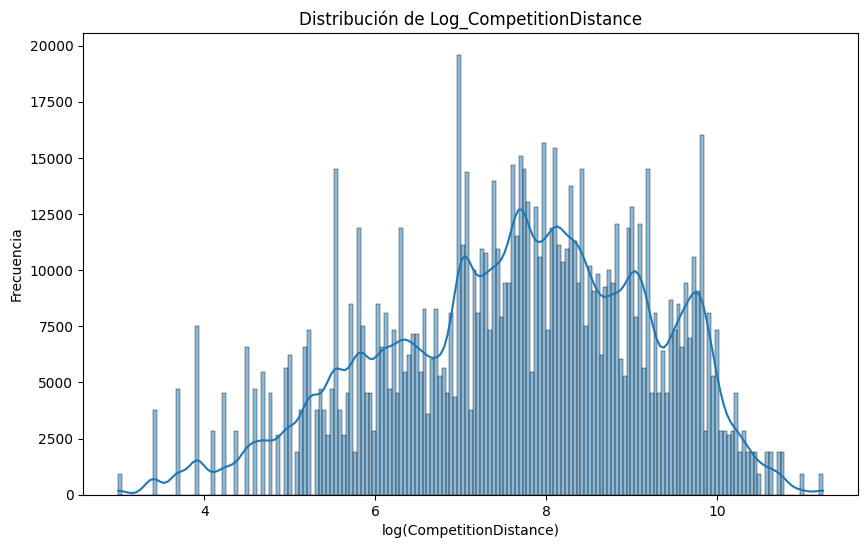

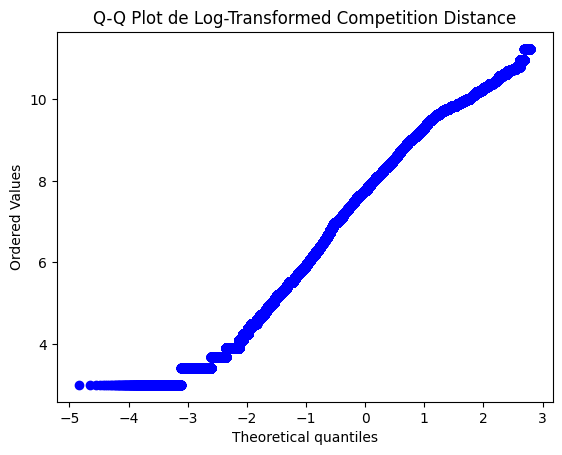

In [14]:
# Histograma
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['Log_CompetitionDistance'], kde=True)
plt.title('Distribución de Log_CompetitionDistance')
plt.xlabel('log(CompetitionDistance)')
plt.ylabel('Frecuencia')
plt.show()

# Q-Q plot
import scipy.stats as stats
fig = plt.figure()
res = stats.probplot(df['Log_CompetitionDistance'], plot=plt)
plt.title('Q-Q Plot de Log-Transformed Competition Distance')
plt.show()

#### Imputación mediante mediana para 'CompetitionDistance'

In [15]:
# Imputación con la mediana
median = df['CompetitionDistance'].median()
df['CompetitionDistance_Median'] = df['CompetitionDistance'].fillna(median)

# Comprobar si aún quedan valores faltantes
print(df['CompetitionDistance_Median'].isnull().sum())

0


#### Imputación mediante la mediana en la variable transformada 'Log_CompetitionDistance'

In [16]:
# Imputación con la mediana
median = df['Log_CompetitionDistance'].median()
df['Log_CompetitionDistance_Median'] = df['Log_CompetitionDistance'].fillna(median)

# Comprobar si aún quedan valores faltantes
print(df['Log_CompetitionDistance_Median'].isnull().sum())

0


### Imputación datos variable 'CompetitionOpenSinceMonth'

#### Verificación previa a la imputación

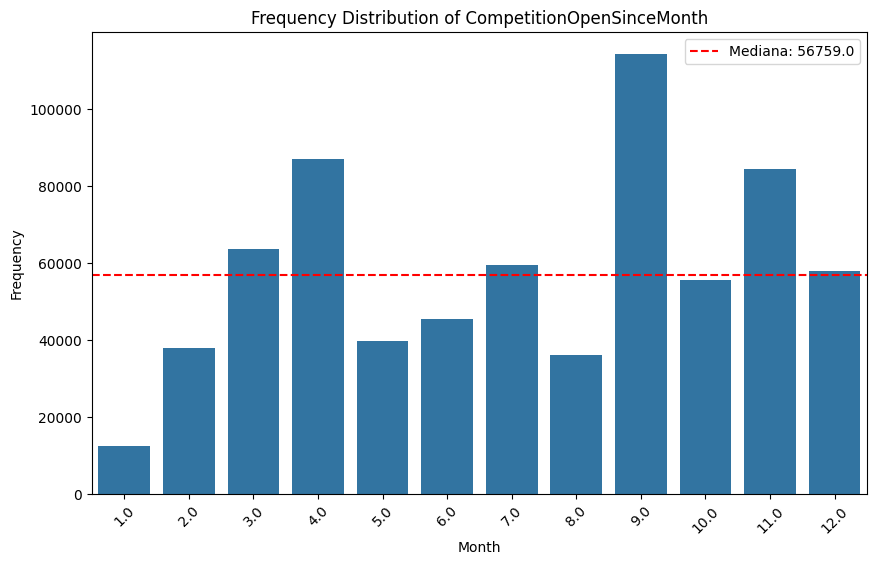

In [17]:
# Conteo de frecuencia de cada categoría
month_counts = df['CompetitionOpenSinceMonth'].value_counts().sort_index()

# Calcula la mediana de las frecuencias de los meses
median_frequency = month_counts.median()

# Gráfico de barras de las frecuencias
plt.figure(figsize=(10, 6))
sns.barplot(x=month_counts.index, y=month_counts.values)
plt.axhline(y=median_frequency, color='red', linestyle='--', label=f'Mediana: {median_frequency}')
plt.title('Frequency Distribution of CompetitionOpenSinceMonth')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotar etiquetas para mejor visualización
plt.legend()  # Muestra la leyenda
plt.show()

#### Imputación

In [18]:
# import math

# competition_distance
# df["competition_distance"] = df["CompetitionDistance"].fillna(200000.0)

# Ensure 'Date' is a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Imputación usando la usando el valor mes de la variable 'Date'
df['CompetitionOpenSinceMonth'] = df.apply(
    lambda x: x['Date'].month if pd.isna(x['CompetitionOpenSinceMonth']) else x['CompetitionOpenSinceMonth'],
    axis=1
)

#### Verificación

Existen 0 valores nulos.


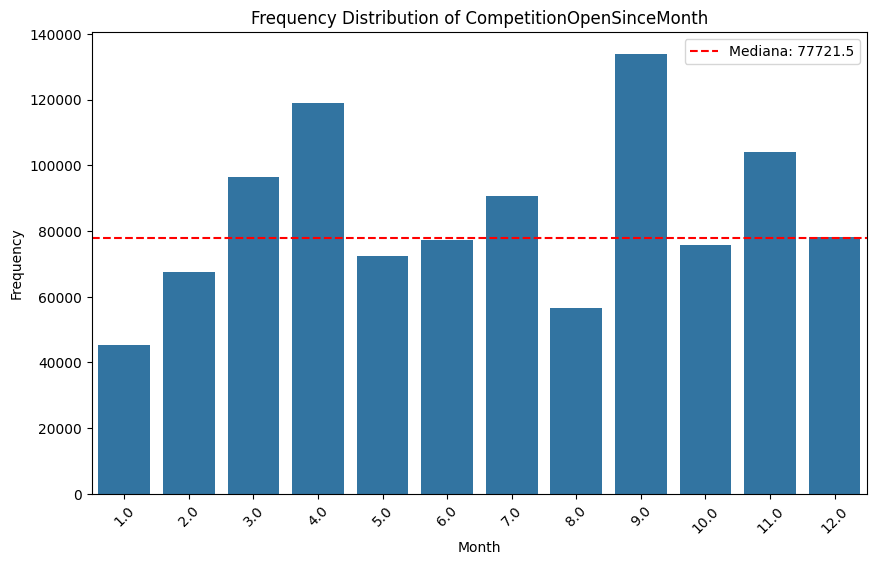

In [19]:
# Verificar nuevamente valores nulos
print(f"Existen {df['CompetitionOpenSinceMonth'].isnull().sum()} valores nulos.")

# Conteo de frecuencia de cada categoría
month_counts = df['CompetitionOpenSinceMonth'].value_counts().sort_index()

# Calcula la mediana de las frecuencias de los meses
median_frequency = month_counts.median()

# Gráfico de barras de las frecuencias
plt.figure(figsize=(10, 6))
sns.barplot(x=month_counts.index, y=month_counts.values)
plt.axhline(y=median_frequency, color='red', linestyle='--', label=f'Mediana: {median_frequency}')
plt.title('Frequency Distribution of CompetitionOpenSinceMonth')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotar etiquetas para mejor visualización
plt.legend()  # Muestra la leyenda
plt.show()

### Imputación datos variable 'CompetitionOpenSinceYear'

#### Verificación previa a la imputación

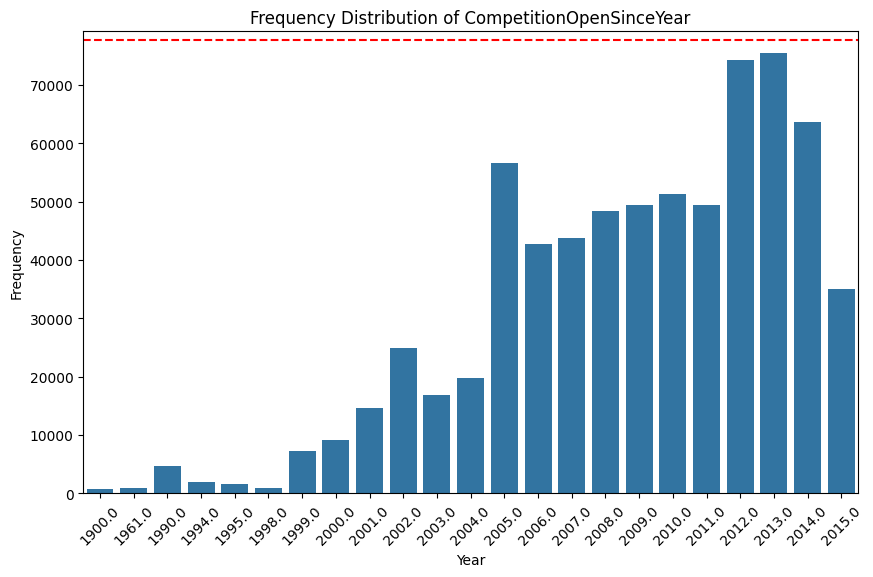

In [20]:
# Conteo de frecuencia de cada categoría
year_counts = df['CompetitionOpenSinceYear'].value_counts().sort_index()

# Calcula la mediana de las frecuencias de los meses
median_frequency = month_counts.median()

# Gráfico de barras de las frecuencias
plt.figure(figsize=(10, 6))
sns.barplot(x=year_counts.index, y=year_counts.values)
plt.axhline(y=median_frequency, color='red', linestyle='--', label=f'Mediana: {median_frequency}')
plt.title('Frequency Distribution of CompetitionOpenSinceYear')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotar etiquetas para mejor visualización
plt.show()

#### Imputación

In [21]:
# 'CompetitionOpenSinceYear' NaN check
df['CompetitionOpenSinceYear'] = df.apply(
    lambda x: x['Date'].year if pd.isna(x['CompetitionOpenSinceYear']) else x['CompetitionOpenSinceYear'],
    axis=1
)

#### Verificación

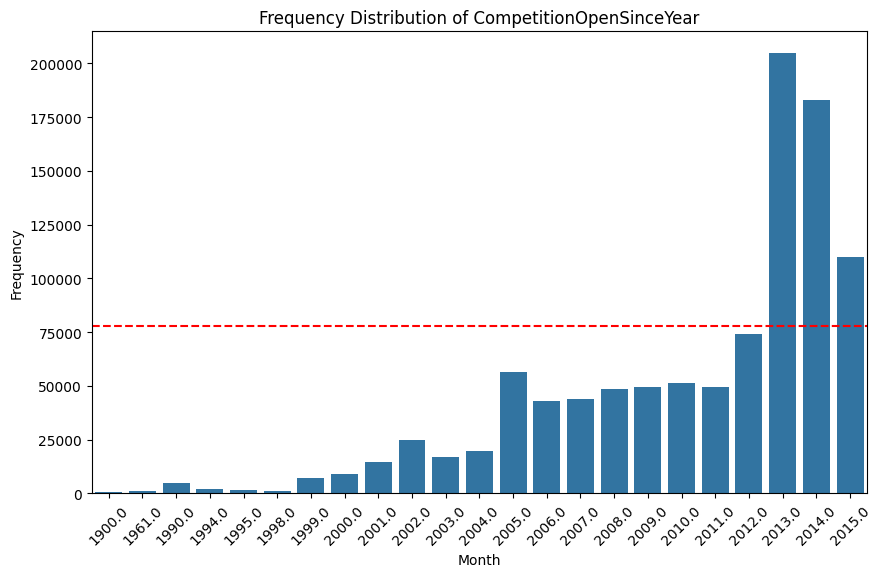

In [22]:
# Conteo de frecuencia de cada categoría
year_counts = df['CompetitionOpenSinceYear'].value_counts().sort_index()

# Calcula la mediana de las frecuencias de los meses
median_frequency = month_counts.median()

# Gráfico de barras de las frecuencias
plt.figure(figsize=(10, 6))
sns.barplot(x=year_counts.index, y=year_counts.values)
plt.axhline(y=median_frequency, color='red', linestyle='--', label=f'Mediana: {median_frequency}')
plt.title('Frequency Distribution of CompetitionOpenSinceYear')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotar etiquetas para mejor visualización
plt.show()

### Imputación datos variable 'Promo2SinceWeek'

#### Verificación previa a la imputación

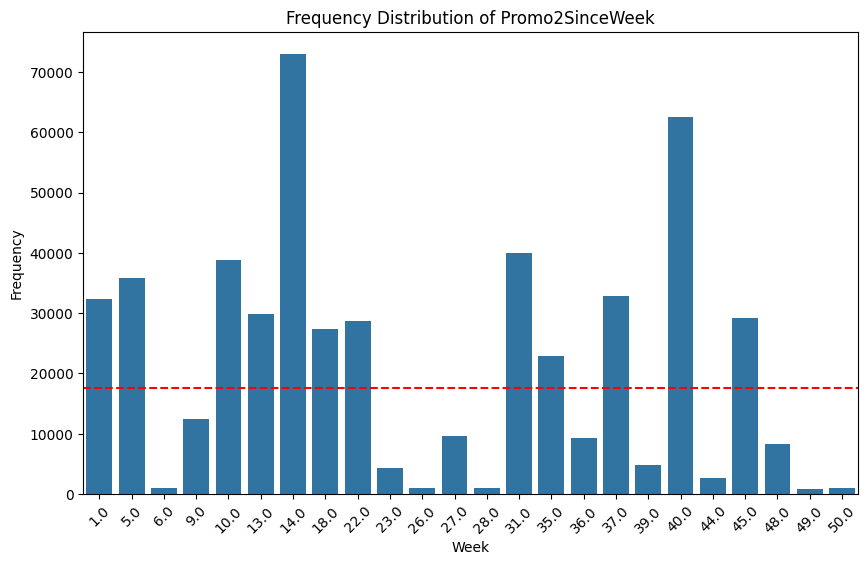

In [23]:
# Conteo de frecuencia de cada categoría
promo2week_counts = df['Promo2SinceWeek'].value_counts().sort_index()

# Calcula la mediana de las frecuencias de los meses
median_frequency = promo2week_counts.median()

# Gráfico de barras de las frecuencias
plt.figure(figsize=(10, 6))
sns.barplot(x=promo2week_counts.index, y=promo2week_counts.values)
plt.axhline(y=median_frequency, color='red', linestyle='--', label=f'Mediana: {median_frequency}')
plt.title('Frequency Distribution of Promo2SinceWeek')
plt.xlabel('Week')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotar etiquetas para mejor visualización
plt.show()

#### Imputación

In [24]:
import math
df["Promo2SinceWeek"] = df.apply(lambda x: x["Date"].week if math.isnan(x["Promo2SinceWeek"]) else x["Promo2SinceWeek"], axis=1)

#### Verificación


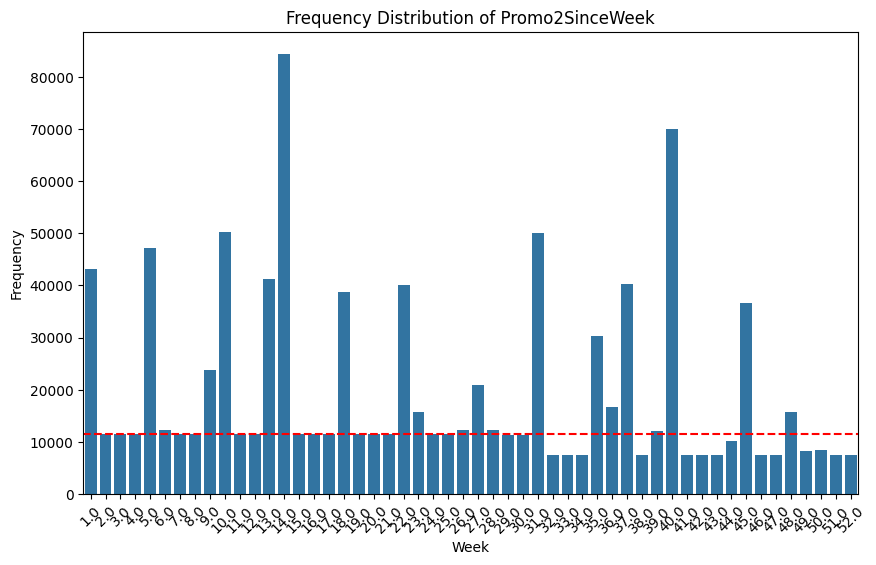

In [25]:
# Conteo de frecuencia de cada categoría
promo2week_counts = df['Promo2SinceWeek'].value_counts().sort_index()

# Calcula la mediana de las frecuencias de los meses
median_frequency = promo2week_counts.median()

# Gráfico de barras de las frecuencias
plt.figure(figsize=(10, 6))
sns.barplot(x=promo2week_counts.index, y=promo2week_counts.values)
plt.axhline(y=median_frequency, color='red', linestyle='--', label=f'Mediana: {median_frequency}')
plt.title('Frequency Distribution of Promo2SinceWeek')
plt.xlabel('Week')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotar etiquetas para mejor visualización
plt.show()

### Imputación datos variable 'Promo2SinceYear'

#### Verificación previa a la imputación

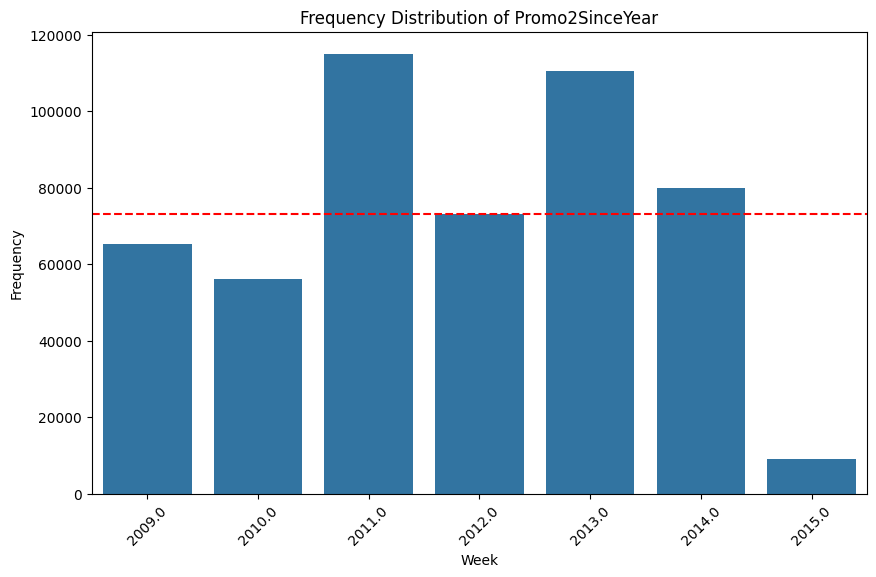

In [26]:
# Conteo de frecuencia de cada categoría
promo2year_counts = df['Promo2SinceYear'].value_counts().sort_index()

# Calcula la mediana de las frecuencias de las categorías
median_frequency = promo2year_counts.median()

# Gráfico de barras de las frecuencias
plt.figure(figsize=(10, 6))
sns.barplot(x=promo2year_counts.index, y=promo2year_counts.values)
plt.axhline(y=median_frequency, color='red', linestyle='--', label=f'Mediana: {median_frequency}')
plt.title('Frequency Distribution of Promo2SinceYear')
plt.xlabel('Week')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotar etiquetas para mejor visualización
plt.show()

#### Imputación

In [27]:
df["Promo2SinceYear"] = df.apply(lambda x: x["Date"].year if math.isnan(x["Promo2SinceYear"]) else x["Promo2SinceYear"], axis=1)

#### Verificación

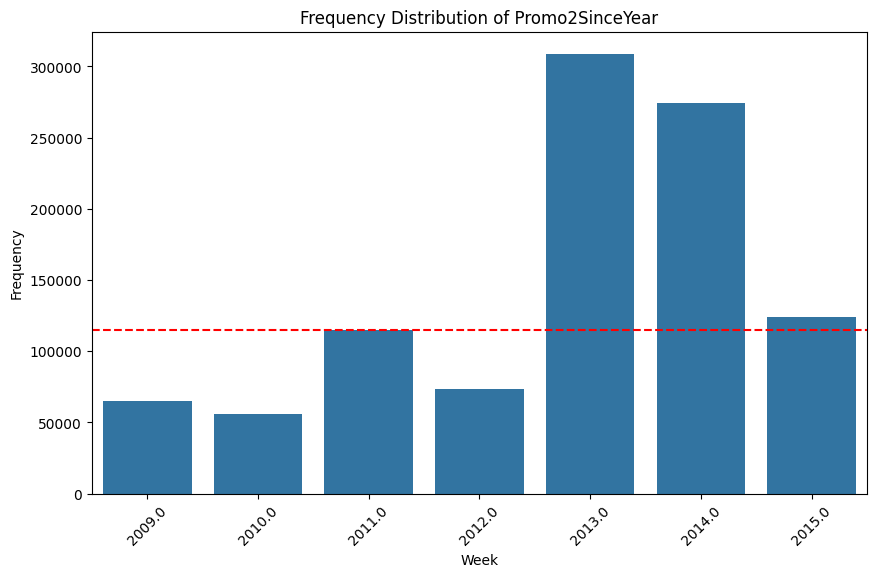

In [28]:
# Conteo de frecuencia de cada categoría
promo2year_counts = df['Promo2SinceYear'].value_counts().sort_index()

# Calcula la mediana de las frecuencias de las categorías
median_frequency = promo2year_counts.median()

# Gráfico de barras de las frecuencias
plt.figure(figsize=(10, 6))
sns.barplot(x=promo2year_counts.index, y=promo2year_counts.values)
plt.axhline(y=median_frequency, color='red', linestyle='--', label=f'Mediana: {median_frequency}')
plt.title('Frequency Distribution of Promo2SinceYear')
plt.xlabel('Week')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotar etiquetas para mejor visualización
plt.show()

### Otras imputaciones

In [29]:
df.isna().sum()

Store                                  0
DayOfWeek                              0
Date                                   0
Customers                              0
Open                                   0
Promo                                  0
StateHoliday                           0
SchoolHoliday                          0
StoreType                              0
Assortment                             0
CompetitionDistance                 2642
CompetitionOpenSinceMonth              0
CompetitionOpenSinceYear               0
Promo2                                 0
Promo2SinceWeek                        0
Promo2SinceYear                        0
PromoInterval                     508031
Log_CompetitionDistance             2642
CompetitionDistance_Median             0
Log_CompetitionDistance_Median         0
dtype: int64

In [30]:
# promo_interval
month_map = {1: "Jan", 2: "Fev", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

In [31]:
df["PromoInterval"].fillna(0, inplace=True)
df["month_map"] = df["Date"].dt.month.map(month_map)

df["IsPromo"] = df[["PromoInterval", "month_map"]].apply(lambda x: 0 if x["PromoInterval"] == 0 else 1 if x["month_map"] in x["PromoInterval"].split(",") else 0, axis=1)



### Conversión y ajuste tipos de datos

In [32]:
df["CompetitionOpenSinceMonth"] = df["CompetitionOpenSinceMonth"].astype(int)
df["CompetitionOpenSinceYear"] = df["CompetitionOpenSinceYear"].astype(int)

df["Promo2SinceWeek"] = df["Promo2SinceWeek"].astype(int)
df["Promo2SinceYear"] = df["Promo2SinceYear"].astype(int)

In [33]:
# year
df['year'] = pd.DatetimeIndex(df['Date']).year

# month
df['month'] = pd.DatetimeIndex(df['Date']).month

# day
df['day'] = pd.DatetimeIndex(df['Date']).day

# week of year
df['week_of_year'] = pd.to_datetime(df['Date']).dt.isocalendar().week

# year week
df['year_week'] = pd.to_datetime(df['Date']).dt.strftime("%Y-%W")


In [34]:
import datetime

# competition since
df["CompetitionSince"] = df.apply(lambda x: datetime.datetime(year=x["CompetitionOpenSinceYear"], month=x["CompetitionOpenSinceMonth"], day=1), axis=1)

df["CompetitionTimeMonth"] = ((df["Date"] - df["CompetitionSince"]) / 30).apply(lambda x: x.days).astype(int)



In [35]:
df[['Promo2','Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']]

,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,0,31,2015,0
1,1,13,2010,"Jan,Apr,Jul,Oct"
2,1,14,2011,"Jan,Apr,Jul,Oct"
3,0,31,2015,0
4,0,31,2015,0
...,...,...,...,...
1017204,1,31,2013,"Jan,Apr,Jul,Oct"
1017205,0,1,2013,0
1017206,0,1,2013,0
1017207,0,1,2013,0


In [36]:
df["PromoSince"] = df["Promo2SinceYear"].astype(str) + "-" + df["Promo2SinceWeek"].astype(str)
df["PromoSince"]

0          2015-31
1          2010-13
2          2011-14
3          2015-31
4          2015-31
            ...   
1017204    2013-31
1017205     2013-1
1017206     2013-1
1017207     2013-1
1017208    2012-22
Name: PromoSince, Length: 1017209, dtype: object

In [37]:
df["PromoSince"] = df["PromoSince"].apply(lambda x: datetime.datetime.strptime(x + "-1", "%Y-%W-%w") - datetime.timedelta(days=7))
df["PromoSince"]

0         2015-07-27
1         2010-03-22
2         2011-03-28
3         2015-07-27
4         2015-07-27
             ...    
1017204   2013-07-29
1017205   2012-12-31
1017206   2012-12-31
1017207   2012-12-31
1017208   2012-05-21
Name: PromoSince, Length: 1017209, dtype: datetime64[ns]

In [38]:
df["PromoTimeWeek"] = ((df["Date"] - df["PromoSince"]) / 7).apply(lambda x: x.days).astype(int)
df["PromoTimeWeek"] .head(10)

0      0
1    279
2    226
3      0
4      0
5      0
6      0
7      0
8      0
9      0
Name: PromoTimeWeek, dtype: int64

In [39]:
# assortment
df["Assortment"] = df["Assortment"].apply(lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended")

# state holiday
df["StateHoliday"] = df["StateHoliday"].apply(lambda x: "public_holiday" if x == "a" else "easter_holiday" if x == "b" else "christmas" if x == "c" else "regular_day")

df[['Assortment','StateHoliday']].head().T



,0,1,2,3,4
Assortment,basic,basic,basic,extended,basic
StateHoliday,regular_day,regular_day,regular_day,regular_day,regular_day


In [40]:
df.head().T

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,regular_day,regular_day,regular_day,regular_day,regular_day
SchoolHoliday,1,1,1,1,1
StoreType,c,a,a,c,a
Assortment,basic,basic,basic,extended,basic


## Análisis Exploratorio de Datos

In [41]:
df2 = df.copy()
df2 = df2.drop(['StateHoliday','StoreType','Assortment','month_map','PromoInterval','Date','year_week','CompetitionSince','PromoSince'], axis=1)
df2.head().T

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
SchoolHoliday,1,1,1,1,1
CompetitionDistance,1270.0,570.0,14130.0,620.0,29910.0
CompetitionOpenSinceMonth,9,11,12,9,4
CompetitionOpenSinceYear,2008,2007,2006,2009,2015
Promo2,0,1,1,0,0


In [42]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 22 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   Store                           1017209 non-null  int64  
 1   DayOfWeek                       1017209 non-null  int64  
 2   Customers                       1017209 non-null  int64  
 3   Open                            1017209 non-null  int64  
 4   Promo                           1017209 non-null  int64  
 5   SchoolHoliday                   1017209 non-null  int64  
 6   CompetitionDistance             1014567 non-null  float64
 7   CompetitionOpenSinceMonth       1017209 non-null  int64  
 8   CompetitionOpenSinceYear        1017209 non-null  int64  
 9   Promo2                          1017209 non-null  int64  
 10  Promo2SinceWeek                 1017209 non-null  int64  
 11  Promo2SinceYear                 1017209 non-null  int64  
 12  

### Crear nuevos datasets para evaluar escenarios experimentales

In [43]:
# Data for experiments
data_exp1 = df2.copy()
data_exp1 = data_exp1.drop(['CompetitionDistance','Log_CompetitionDistance', 'Log_CompetitionDistance_Median'], axis=1)

data_exp2 = df2.copy()
data_exp2 = data_exp2.drop(['CompetitionDistance','Log_CompetitionDistance', 'CompetitionDistance_Median'], axis=1)

## Machine learning: Regresión lineal multivariada, Light GBM, Random Forests, XGboost

### Libraries

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE, r2_score
from sklearn.metrics import mean_absolute_error as MAE

### Particionar datos

In [45]:
## Particionar el conjunto de datos para crear datos de entrenamiento, evaluación y validación.
sc = StandardScaler()
Xsc = sc.fit(data_exp1)
X = Xsc.transform(data_exp1)
X.shape

X_train, X_test, y_train, y_test = split(X,target,
                                         test_size=0.30,
                                         random_state=42)
X_train, X_valid, y_train, y_valid = split(X_train, y_train,
                                           test_size=0.2)
print("El tamaño de los nuevos subconjuntos es: ", X_train.shape, X_test.shape, X_valid.shape)
print("Y es la variable que tiene las etiquetas de las clases a predecir: ", y_train.shape, y_test.shape, y_valid.shape)

El tamaño de los nuevos subconjuntos es:  (569636, 19) (305163, 19) (142410, 19)
Y es la variable que tiene las etiquetas de las clases a predecir:  (569636,) (305163,) (142410,)


### Multivariate lineal regression

In [47]:
# Define model and prediction
ols = LinearRegression()
model1 = ols.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)

In [48]:
# accuracy check
mse = MSE(y_test, y_pred1)
rmse = MSE(y_test, y_pred1, squared=False)
mae = MAE(y_test, y_pred1)
r2 = r2_score(y_test, y_pred1)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("MAE: %.2f" % mae)
print("R2: %.2f" % r2)

MSE: 2111120.01
RMSE: 1452.97
MAE: 979.05
R2: 0.86


### Light GBM
https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/   
https://www.datatechnotes.com/2022/03/lightgbm-regression-example-in-python.html  

In [49]:
# !pip install lightgbm

In [50]:
import lightgbm as lgb

In [ ]:
# model2 = lgb.LGBMRegressor(learning_rate=0.05, max_depth=-5, random_state=42)
# model2.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)],
        #   verbose=0, eval_metric='logloss')

In [51]:
# Hyperparameters
params = {
    'task': 'train',
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learning_rate': 0.05,
    'metric': {'l2','l1'},
    'header' : 'true',
    'verbose': 0
}

# laoding data
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# fitting the model
model2 = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval)
# Pred
y_pred2 = model2.predict(X_test)

In [52]:
# accuracy check
mse = MSE(y_test, y_pred2)
rmse = MSE(y_test, y_pred2, squared=False)
mae = MAE(y_test, y_pred2)
r2 = r2_score(y_test, y_pred2)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("MAE: %.2f" % mae)
print("R2: %.2f" % r2)

MSE: 1342118.52
RMSE: 1158.50
MAE: 776.34
R2: 0.91


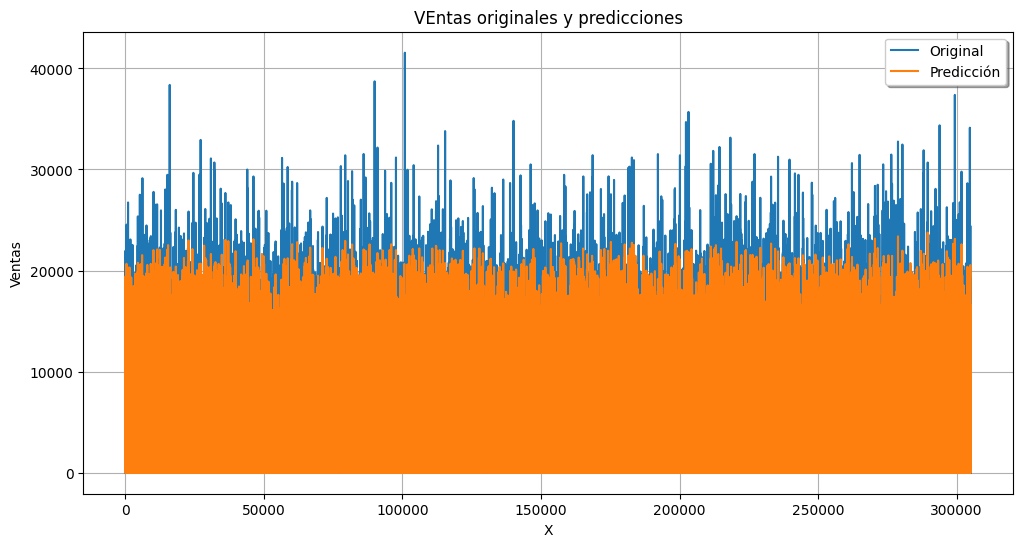

In [53]:
# visualizing in a plot
x_ax = range(len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test, label="Original")
plt.plot(x_ax, y_pred2, label="Predicción")
plt.title("VEntas originales y predicciones")
plt.xlabel('X')
plt.ylabel('Ventas')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

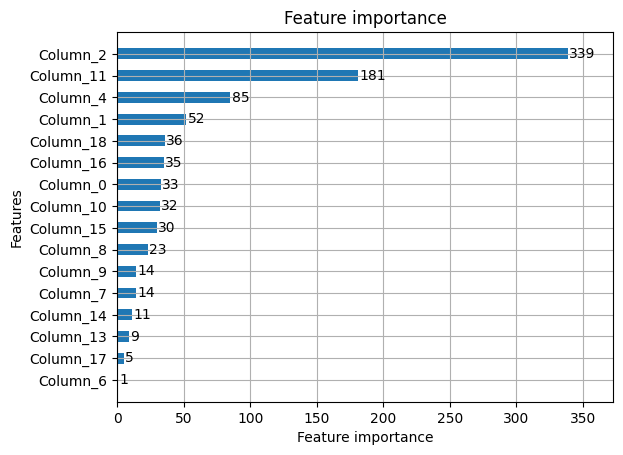

In [54]:
# plotting feature importance
lgb.plot_importance(model2, height=.5)

<Axes: >

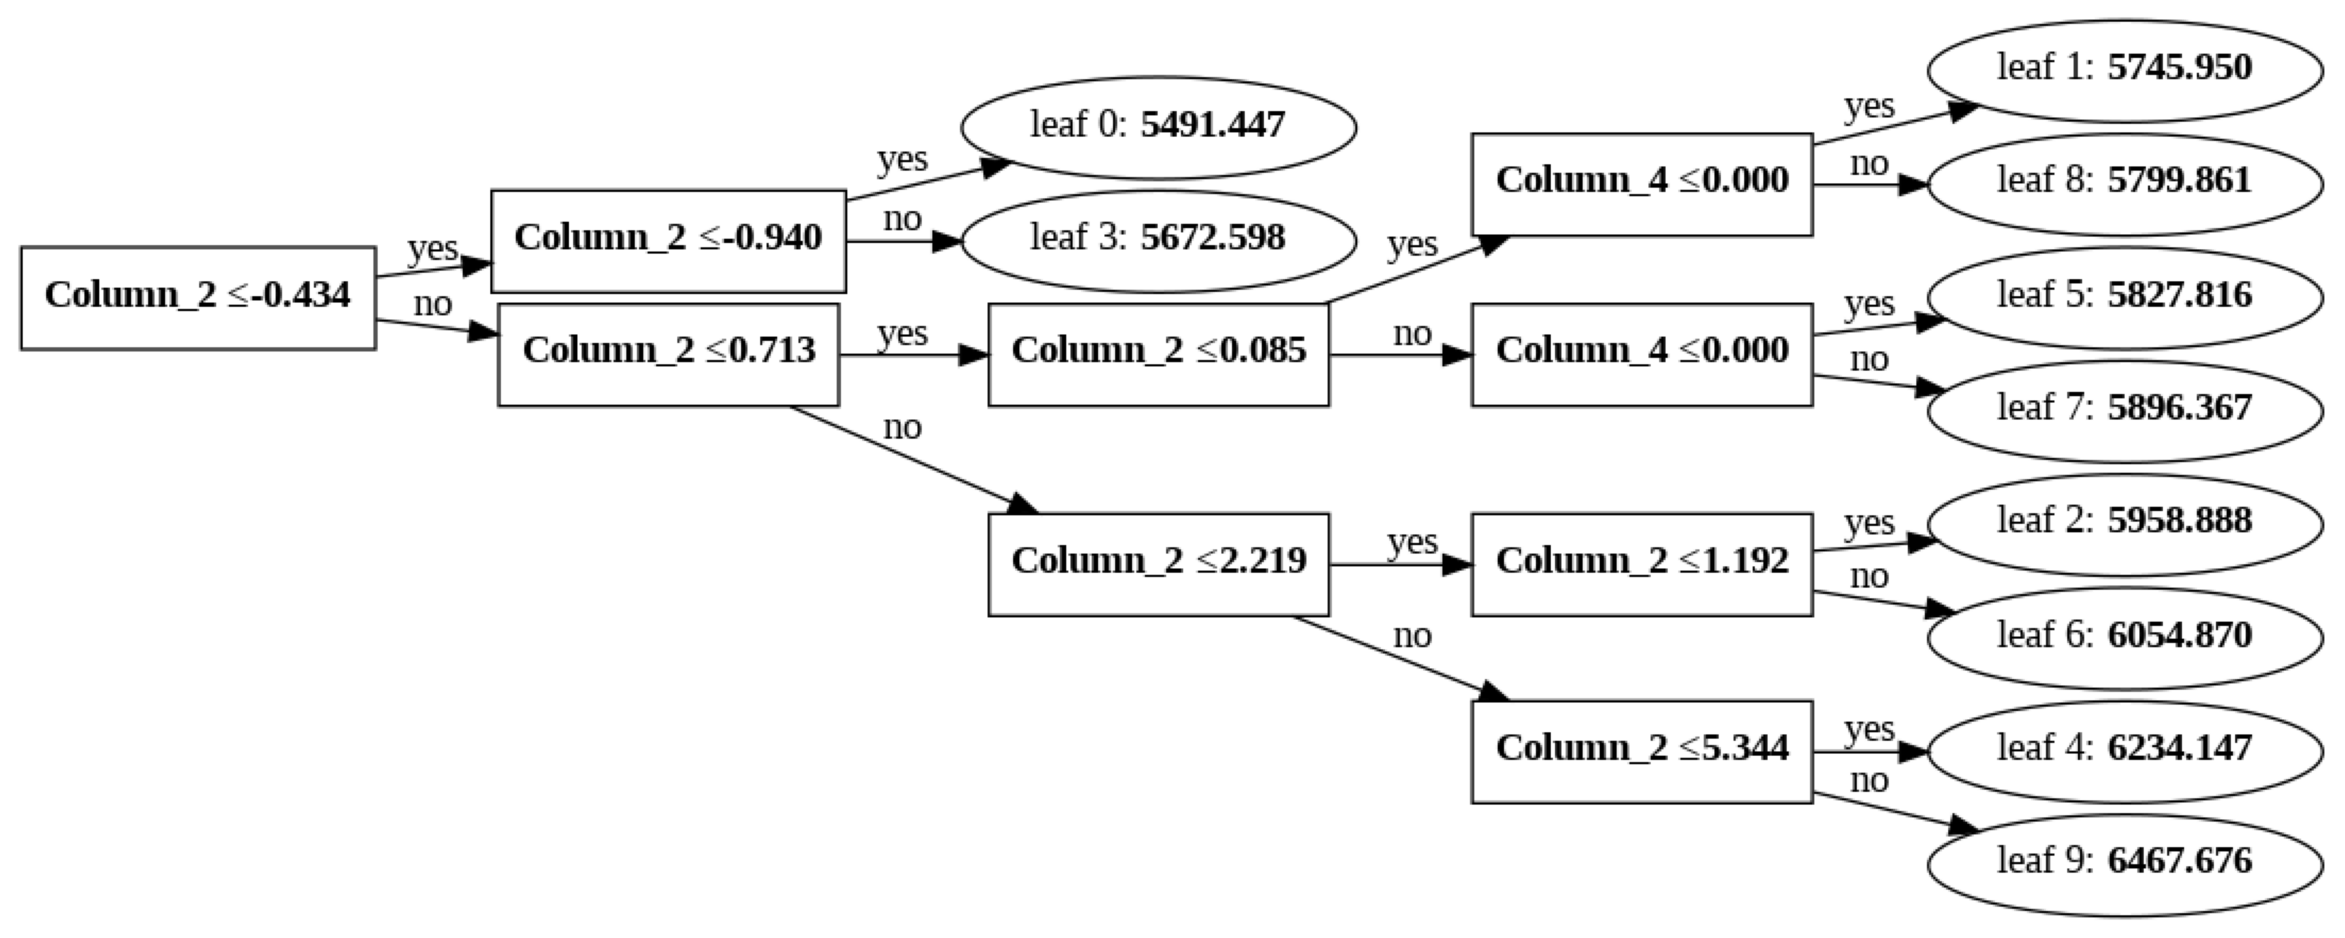

In [55]:
lgb.plot_tree(model2,figsize=(30,40))

### Random Forest Regressor

In [56]:
from sklearn.ensemble import RandomForestRegressor

In [58]:
model3 = RandomForestRegressor()
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)

In [59]:
# accuracy check
mse = MSE(y_test, y_pred3)
rmse = MSE(y_test, y_pred3, squared=False)
mae = MAE(y_test, y_pred3)
r2 = r2_score(y_test, y_pred3)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("MAE: %.2f" % mae)
print("R2: %.2f" % r2)

MSE: 247635.59
RMSE: 497.63
MAE: 287.34
R2: 0.98


### Xgboost regressor
https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html

In [60]:
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb
from sklearn.metrics import classification_report

In [61]:
#Define model
model4 = xgb.XGBRegressor(objective ='reg:squarederror',
                          booster='gbtree',
                          colsample_bytree = 1,
                          importance_type='gain',
                          learning_rate = 0.2,
                          max_depth = 5,
                          alpha = 5,
                          n_estimators = 200,
                          seed=123)

In [62]:
#Training
model4.fit(X_train, y_train)#,
#         eval_set=[(X_train, y_train), (X_test, y_test)], \
#         eval_metric='mlogloss', verbose=False)

XGBRegressor(alpha=5, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [64]:
#K-fold cross validation
scores = cross_val_score(model4, X_train, y_train, cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.97


In [65]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(model4, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.97


In [66]:
# Pred
y_pred4 = model4.predict(X_test)

In [67]:
# accuracy check
mse = MSE(y_test, y_pred4)
rmse = MSE(y_test, y_pred4, squared=False)
mae = MAE(y_test, y_pred4)
r2 = r2_score(y_test, y_pred4)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("MAE: %.2f" % mae)
print("R2: %.2f" % r2)

MSE: 407277.35
RMSE: 638.18
MAE: 439.02
R2: 0.97


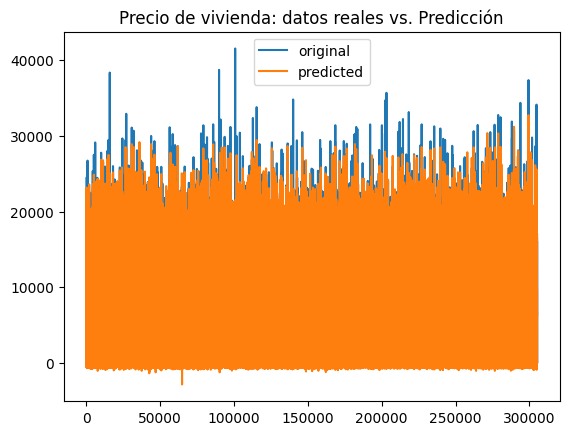

In [68]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred4, label="predicted")
plt.title("Precio de vivienda: datos reales vs. Predicción")
plt.legend()
plt.show()

## Entrenamiento del modelo predictivo basado en RNA

In [ ]:
# Optimización de hiperparámetros
#funcion de activacion
#loss
#metrics
#optimizer
#learning_rate
#epochs
#batch_size

In [77]:
nco = 5
lr = 0.01
modelRNA = models.Sequential()
modelRNA.add(Dense(nco, batch_input_shape=(None, 19), activation='relu')) ## neuronas en la capa de entrada (batch_input_shape) y #neuronas en la primera capa oculta
modelRNA.add(Dense(1, activation='relu'))

# compile the keras (tensorflow) flow graph
modelRNA.compile(optimizer=optimizers.Adam(learning_rate=lr),
                 loss='mse',
                 metrics=[keras.metrics.RootMeanSquaredError()])

training_log = modelRNA.fit(X_train,
                            y_train,
                            epochs=150,
                            batch_size=32,
                            validation_data=(X_valid, y_valid),
                            verbose=0)

KeyboardInterrupt: 

# CODIGO SIN DEPURAR DESDE ESTA SECCIÓN
#¡POR FAVOR NO EJECUTAR!

In [ ]:
X_pred = modelRNA.predict(X_test, batch_size = 32, verbose=1)
y_pred = np.argmax(X_pred, axis=1)
print(y_pred.shape)

In [ ]:
  # Y_pred = np_utils.to_categorical(y_pred)
  # auc = roc_auc_score(Y_test, Y_pred)

### HPO Número de neuronas y learning rate - Diseño de la arquitectura del modelo

In [69]:
def hponeuronas (neuronascapaoculta, lr):
  # Definir la arquitectura del modelo de la RNA
  modelRNA = models.Sequential()
  modelRNA.add(Dense(neuronascapaoculta, batch_input_shape=(None, 22), activation='relu')) ## neuronas en la capa de entrada (batch_input_shape) y #neuronas en la primera capa oculta
  modelRNA.add(Dense(1, activation='relu'))

  # compile the keras (tensorflow) flow graph
  modelRNA.compile(optimizer=optimizers.RMSprop(learning_rate=lr),
                loss='rmse',
                metrics=['rmse'])

  training_log = modelRNA.fit(X_train,
                              Y_train,
                              epochs=150,
                              batch_size=32,
                              validation_data=(X_valid, Y_valid),
                              verbose=0)

  X_pred = modelRNA.predict(X_test, batch_size = 32, verbose=1)
  y_pred = np.argmax(X_pred, axis=1)
  print(y_pred.shape)

  Y_pred = np_utils.to_categorical(y_pred)
  auc = roc_auc_score(Y_test, Y_pred)
  print("Valor curva ROC con ",neuronascapaoculta, " Neuronas y Learning Rate ", lr, ": ", auc)

In [73]:
for i in [1, 2, 3, 4]:
  for j in [0.0001, 0.001, 0.01, 0.1, 0.5, 0.9, 1]:
     hponeuronas(i, j)

In [ ]:
for i in range(1,150,15):
  for j in [0.001, 0.01]:
     hponeuronas(i, j)

29/29 [==============================] - 0s 1ms/step
(900,)
Valor curva ROC con  1  Neuronas y Learning Rate  0.001 :  0.6805839338019933
29/29 [==============================] - 0s 1ms/step
(900,)
Valor curva ROC con  1  Neuronas y Learning Rate  0.01 :  0.8193050642082055
29/29 [==============================] - 0s 2ms/step
(900,)
Valor curva ROC con  16  Neuronas y Learning Rate  0.001 :  0.8490359143281205
29/29 [==============================] - 0s 1ms/step
(900,)
Valor curva ROC con  16  Neuronas y Learning Rate  0.01 :  0.8285105301441776
29/29 [==============================] - 0s 2ms/step
(900,)
Valor curva ROC con  31  Neuronas y Learning Rate  0.001 :  0.8344617431060787
29/29 [==============================] - 0s 2ms/step
(900,)
Valor curva ROC con  31  Neuronas y Learning Rate  0.01 :  0.8135544330301808
29/29 [==============================] - 0s 2ms/step
(900,)
Valor curva ROC con  46  Neuronas y Learning Rate  0.001 :  0.8368319003318021
29/29 [=========================

In [ ]:
for i in range(1, 100, 5):
  hponeuronas(i, 0.001)

29/29 [==============================] - 0s 7ms/step
(900,)
Valor curva ROC  0.8150534007081568
29/29 [==============================] - 0s 2ms/step
(900,)
Valor curva ROC  0.863231655896301
29/29 [==============================] - 0s 2ms/step
(900,)
Valor curva ROC  0.8450170094894697
29/29 [==============================] - 0s 3ms/step
(900,)
Valor curva ROC  0.8643404368831384
29/29 [==============================] - 0s 1ms/step
(900,)
Valor curva ROC  0.860277059877126
29/29 [==============================] - 0s 2ms/step
(900,)
Valor curva ROC  0.8439416673776208
29/29 [==============================] - 0s 2ms/step
(900,)
Valor curva ROC  0.8558633370321362
29/29 [==============================] - 0s 1ms/step
(900,)
Valor curva ROC  0.8477423118614807
29/29 [==============================] - 0s 3ms/step
(900,)
Valor curva ROC  0.8461390514611012
29/29 [==============================] - 0s 2ms/step
(900,)
Valor curva ROC  0.8489652316560171
29/29 [==============================] - 0

In [ ]:
 hponeuronas(16, 0.01)

29/29 [==============================] - 0s 2ms/step
(900,)
Valor curva ROC  0.8521436094448447


In [ ]:
# Métricas de desempeño
# Mostrar la precisión, recall, F1-score
print("\n", classification_report(y_test, y_pred, digits=3))


               precision    recall  f1-score   support

           0      0.843     0.800     0.821       175
           1      0.696     0.728     0.712       246
           2      0.895     0.891     0.893       479

    accuracy                          0.829       900
   macro avg      0.812     0.806     0.809       900
weighted avg      0.831     0.829     0.830       900



### Visualizar matriz de confusión

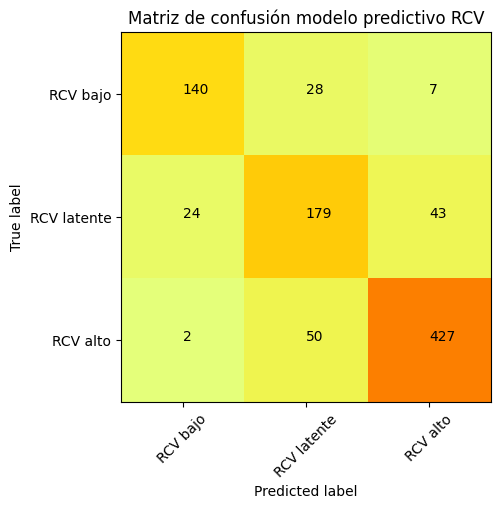

In [ ]:
# Matriz de confusión
# cm = metrics.confusion_matrix(Y_test.argmax(axis=1),
#                               Y_pred.argmax(axis=1))
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['RCV bajo','RCV latente', 'RCV alto']
plt.title('Matriz de confusión modelo predictivo RCV')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
for i in range(3):
    for j in range(3):
        plt.text(j,i, str(cm[i][j]))

### Curva ROC


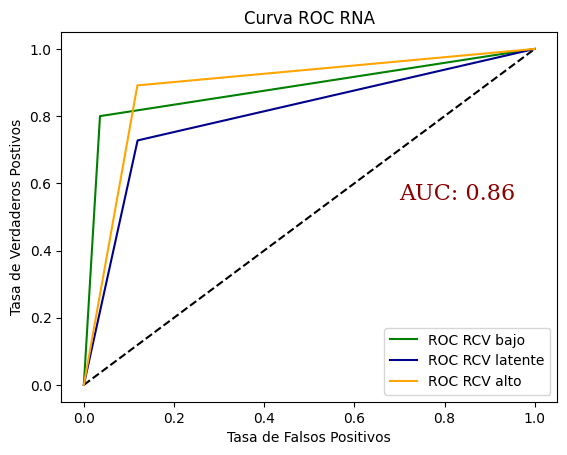

In [ ]:
# Curva ROC
# #https://stackabuse.com/understanding-roc-curves-with-python/
Y_pred = np_utils.to_categorical(y_pred)
auc = roc_auc_score(Y_test, Y_pred)
fpr, tpr, threshold = roc_curve(Y_test[:,0], Y_pred[:,0])
font = {'family': 'serif',
    'color':  'darkred',
    'weight': 'normal',
    'size': 16,
    }
plt.plot(fpr, tpr, color='green', label='ROC RCV bajo')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Postivos')
plt.title('Curva ROC RNA')
fpr, tpr, threshold = roc_curve(Y_test[:,1], Y_pred[:,1])
plt.plot(fpr, tpr, color='darkblue', label='ROC RCV latente')
fpr, tpr, threshold = roc_curve(Y_test[:,2], Y_pred[:,2])
plt.plot(fpr, tpr, color='orange', label='ROC RCV alto')
plt.text(0.7, 0.55, 'AUC: %.2f' % auc, fontdict=font)
plt.legend()
plt.show()

In [ ]:
#Guardar modelo
# import pickle
# pickle.dump(modelRNA, open('RNA_RCV_01.pkl', 'wb'))

# #Cargar modelo almacenado
# model = pickle.load(open('RNA_RCV_01.pkl', 'rb'))
# result_val = model.score(X_valid, y_valid)
# result_test = model.score(X_test, y_test)
# print(result_val)
# print(result_test)

## Conclusiones
